# Entrenamiento y Validación de los diferentes modelos de Clasificación

### Importación de las librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer, ConfusionMatrixDisplay, classification_report, confusion_matrix, roc_curve, auc
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as SkPipe

### Lectura e integración de los datos

#### Lectura de los datos de análisis de toxinas.

In [2]:
df_toxinas = df_toxinas = pd.read_excel("completo_TPM.xlsx")
df_toxinas.head()

,Fecha,Resultado_cat
0,2021-01-01,0
1,2021-01-02,0
2,2021-01-03,0
3,2021-01-04,0
4,2021-01-05,0


#### Lectura de los datos meteorológicos

In [3]:
df_meteorologicos = pd.read_csv("POWER_LARC_unido.csv")
df_meteorologicos.head()

,Fecha,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_KT,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_UVA,...,PRECTOTCORR,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,2021-01-01,4.32,9.02,4.69,2.35,0.36,7.87,2.04,4.06,0.28,...,1.92,97.00,7.16,10.23,3.44,6.79,10.21,13.93,6.00,7.93
1,2021-01-02,7.82,9.37,11.92,1.36,0.64,6.75,3.46,4.09,0.45,...,0.10,96.55,10.71,13.00,6.44,6.56,14.09,16.77,9.09,7.68
2,2021-01-03,6.36,9.41,6.19,3.02,0.53,6.88,2.83,4.08,0.38,...,1.95,97.43,7.42,9.42,6.07,3.35,9.48,11.42,8.46,2.96
3,2021-01-04,4.55,9.18,1.79,3.53,0.38,7.27,2.08,4.05,0.30,...,2.11,98.45,7.79,9.16,6.03,3.13,10.08,11.74,8.61,3.13
4,2021-01-05,6.41,9.13,6.15,3.56,0.53,7.24,2.90,4.04,0.39,...,0.17,98.60,6.30,7.91,3.00,4.91,8.61,10.11,5.49,4.62


Visualización de la cantidad de registros por cada categoría

In [4]:
df_toxinas["Resultado_cat"].value_counts()

1    738
2    386
0    336
Name: Resultado_cat, dtype: int64

### Preparación de los datos antes del entrenamiento

Transformación de las columnas de fecha a tipo de dato datetime

In [5]:
df_toxinas["Fecha"] = pd.to_datetime(df_toxinas["Fecha"])
df_meteorologicos["Fecha"] = pd.to_datetime(df_meteorologicos["Fecha"])

Unión de ambos dataframes

In [6]:
df_unido = pd.merge(df_toxinas, df_meteorologicos, on="Fecha", how="inner")
df_unido.head()

,Fecha,Resultado_cat,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_KT,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,...,PRECTOTCORR,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,2021-01-01,0,4.32,9.02,4.69,2.35,0.36,7.87,2.04,4.06,...,1.92,97.00,7.16,10.23,3.44,6.79,10.21,13.93,6.00,7.93
1,2021-01-02,0,7.82,9.37,11.92,1.36,0.64,6.75,3.46,4.09,...,0.10,96.55,10.71,13.00,6.44,6.56,14.09,16.77,9.09,7.68
2,2021-01-03,0,6.36,9.41,6.19,3.02,0.53,6.88,2.83,4.08,...,1.95,97.43,7.42,9.42,6.07,3.35,9.48,11.42,8.46,2.96
3,2021-01-04,0,4.55,9.18,1.79,3.53,0.38,7.27,2.08,4.05,...,2.11,98.45,7.79,9.16,6.03,3.13,10.08,11.74,8.61,3.13
4,2021-01-05,0,6.41,9.13,6.15,3.56,0.53,7.24,2.90,4.04,...,0.17,98.60,6.30,7.91,3.00,4.91,8.61,10.11,5.49,4.62


Separamos en dataset de Presencia/Ausencia y Peligrosidad

In [7]:
# Crear columna PresenciaToxina: 1 si hay toxina (clase 1 o 2), 0 si no hay (clase 0)
df_unido["PresenciaToxina"] = df_unido["Resultado_cat"].apply(lambda x: 0 if x == 0 else 1)

# Crear columna Peligrosidad: 1 si supera el límite (clase 2), 0 si no (clase 0 o 1)
df_unido["Peligrosidad"] = df_unido["Resultado_cat"].apply(lambda x: 1 if x == 2 else 0)

Registros por categoría dataframe presencia/ausencia

In [8]:
df_unido["PresenciaToxina"].value_counts()

1    1124
0     336
Name: PresenciaToxina, dtype: int64

Separacion datos de validacion final

In [9]:
df_modelo, df_val_final = train_test_split(
    df_unido,
    test_size=0.10,
    stratify=df_unido["Resultado_cat"],
    random_state=42
)

Eliminacion de columnas innecesarias de cada dataframe

In [10]:
df_presencia = df_modelo.drop(columns=["Resultado_cat", "Peligrosidad"])
df_peligrosidad = df_modelo.drop(columns=["Resultado_cat", "PresenciaToxina"])

In [11]:
# Separar variables predictoras y objetivo
X_presencia = df_presencia.drop(columns=["Fecha", "PresenciaToxina"])
y_presencia = df_presencia["PresenciaToxina"]

# Separar conjunto de validación (estratificado)
X_train, X_val, y_train, y_val = train_test_split(
    X_presencia, y_presencia, test_size=0.2, stratify=y_presencia, random_state=42
)

Aplicación de la técnica SMOTE para balancear las clases

In [12]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

### Entrenamiento de los distintos modelos

Definición de modelos

In [13]:
scorer = make_scorer(f1_score)

modelos = {
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10],
            "clf__min_samples_split": [2, 5]
        }
    ),
    "XGBoost": (
        XGBClassifier(random_state=42, eval_metric="logloss"),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.05, 0.1]
        }
    ),
    "Logistic Regression": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=1000))
        ]),
        {
            "clf__C": [0.1, 1, 10]
        }
    ),
    "SVM": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC())
        ]),
        {
            "clf__C": [0.1, 1],
            "clf__kernel": ["linear", "rbf"]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1],
            "clf__max_depth": [3, 5]
        }
    )
}

Entrenamiento y métricas de resultado de los distintos modelos

In [14]:
resultados = {}

for nombre, (modelo, grilla) in modelos.items():
    print(f"\n🔍 Entrenando {nombre}...")

    if isinstance(modelo, SkPipe):
        pipeline = Pipeline(
            [("smote", SMOTE(random_state=42))] 
            + modelo.steps
        )
        grilla_ajustada = grilla

    else:
        pipeline = Pipeline([
            ("smote", SMOTE(random_state=42)),
            ("clf", modelo)
        ])
        grilla_ajustada = grilla

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=grilla_ajustada,
        scoring=scorer,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)

    resultados[nombre] = {
        "mejor_modelo": grid.best_estimator_,
        "mejor_score": grid.best_score_,
        "mejores_params": grid.best_params_
    }
    print(f"✅ Mejor F1-score: {grid.best_score_:.3f}")
    print(f"📌 Hiperparámetros: {grid.best_params_}")

# --------------  
mejor_nombre_presencia = max(resultados, key=lambda k: resultados[k]["mejor_score"])
mejor_modelo_presencia = resultados[mejor_nombre_presencia]["mejor_modelo"]
print(f"\n🏆 Mejor modelo para Presencia de Toxina: {mejor_nombre_presencia}")
# --------------


y_val_pred = mejor_modelo_presencia.predict(X_val)

print("📊 Evaluación del mejor modelo en conjunto de validación:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


🔍 Entrenando Random Forest...
✅ Mejor F1-score: 0.826
📌 Hiperparámetros: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

🔍 Entrenando XGBoost...
✅ Mejor F1-score: 0.814
📌 Hiperparámetros: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}

🔍 Entrenando Logistic Regression...
✅ Mejor F1-score: 0.685
📌 Hiperparámetros: {'clf__C': 10}

🔍 Entrenando SVM...
✅ Mejor F1-score: 0.685
📌 Hiperparámetros: {'clf__C': 1, 'clf__kernel': 'rbf'}

🔍 Entrenando Gradient Boosting...
✅ Mejor F1-score: 0.817
📌 Hiperparámetros: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}

🏆 Mejor modelo para Presencia de Toxina: Random Forest
📊 Evaluación del mejor modelo en conjunto de validación:
[[ 23  37]
 [ 26 177]]
              precision    recall  f1-score   support

           0       0.47      0.38      0.42        60
           1       0.83      0.87      0.85       203

    accuracy                           0.76       263
 

Visualización matriz de confusión

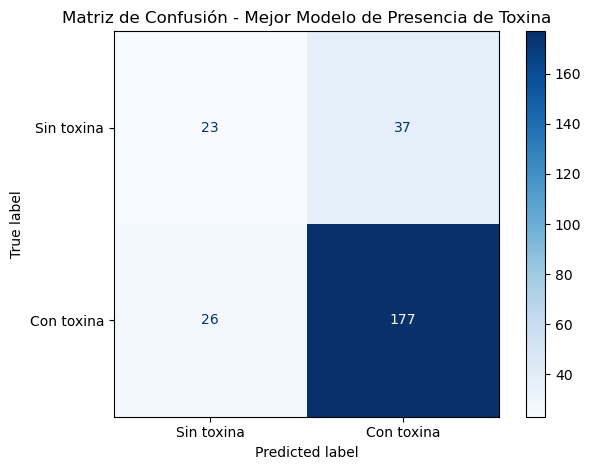

In [15]:
disp = ConfusionMatrixDisplay.from_estimator(
    mejor_modelo_presencia,
    X_val,
    y_val,
    display_labels=["Sin toxina", "Con toxina"],
    cmap="Blues",
    values_format="d"
    
)

plt.title("Matriz de Confusión - Mejor Modelo de Presencia de Toxina")
plt.grid(False)
plt.tight_layout()
plt.show()

Visualizacion curva ROC

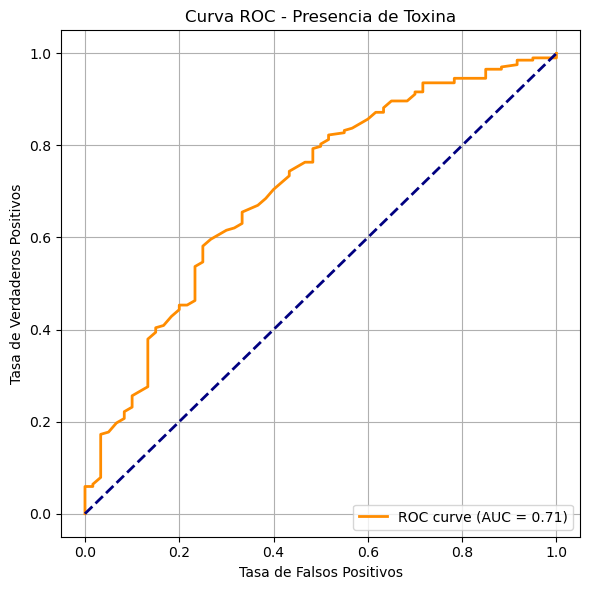

In [ ]:
y_scores = mejor_modelo_presencia.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Presencia de Toxina")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Visualización comparativa de modelos

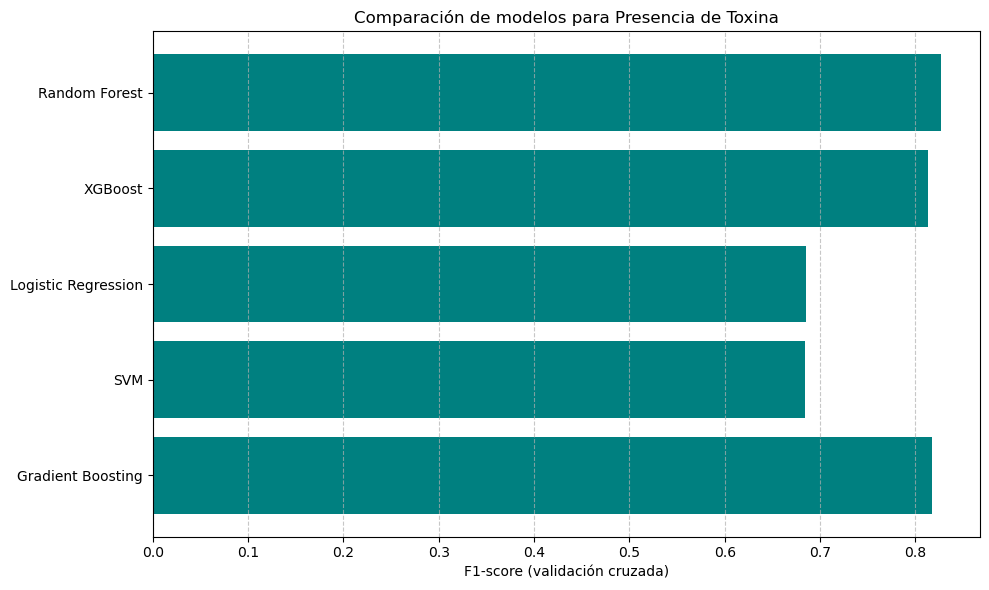

In [ ]:
nombres_modelos = list(resultados.keys())
f1_scores = [info["mejor_score"] for info in resultados.values()]

plt.figure(figsize=(10, 6))
plt.barh(nombres_modelos, f1_scores, color="teal")
plt.xlabel("F1-score (validación cruzada)")
plt.title("Comparación de modelos para Presencia de Toxina")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Repetimos proceso para el dataframe de peligrosidad

In [16]:
X_peligrosidad = df_peligrosidad.drop(columns=["Fecha", "Peligrosidad"])
y_peligrosidad = df_peligrosidad["Peligrosidad"]

X_train_p, X_val_p, y_train_p, y_val_p = train_test_split(
    X_peligrosidad, y_peligrosidad, test_size=0.2, stratify=y_peligrosidad, random_state=42
)

In [17]:
smote_p = SMOTE(random_state=42)
X_res_p, y_res_p = smote_p.fit_resample(X_train_p, y_train_p)

In [18]:
scorer = make_scorer(f1_score)

modelos_p = {
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10],
            "clf__min_samples_split": [2, 5]
        }
    ),
    "XGBoost": (
        XGBClassifier(random_state=42, eval_metric="logloss"),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.05, 0.1]
        }
    ),
    "Logistic Regression": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=1000))
        ]),
        {
            "clf__C": [0.1, 1, 10]
        }
    ),
    "SVM": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC())
        ]),
        {
            "clf__C": [0.1, 1],
            "clf__kernel": ["linear", "rbf"]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1],
            "clf__max_depth": [3, 5]
        }
    )
}

In [19]:
resultados_p = {}

for nombre, (modelo, grilla) in modelos_p.items():
    print(f"\n🔍 Entrenando {nombre}...")
    
    if not isinstance(modelo, Pipeline):
        modelo = Pipeline([("clf", modelo)])
    
    grid = GridSearchCV(
        estimator=modelo,
        param_grid=grilla,
        scoring=scorer,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_res_p, y_res_p)
    resultados_p[nombre] = {
        "mejor_modelo": grid.best_estimator_,
        "mejor_score": grid.best_score_,
        "mejores_params": grid.best_params_
    }
    print(f"✅ Mejor F1-score: {grid.best_score_:.3f}")
    print(f"📌 Hiperparámetros: {grid.best_params_}")

# Encontrar el nombre del modelo con mejor F1-score
mejor_nombre_peligrosidad = max(resultados_p, key=lambda k: resultados_p[k]["mejor_score"])

# Guardar el mejor modelo en una variable
mejor_modelo_peligrosidad = resultados_p[mejor_nombre_peligrosidad]["mejor_modelo"]

print(f"\n🏆 Mejor modelo para Peligrosidad: {mejor_nombre_peligrosidad}")



🔍 Entrenando Random Forest...
✅ Mejor F1-score: 0.816
📌 Hiperparámetros: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

🔍 Entrenando XGBoost...
✅ Mejor F1-score: 0.797
📌 Hiperparámetros: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}

🔍 Entrenando Logistic Regression...
✅ Mejor F1-score: 0.644
📌 Hiperparámetros: {'clf__C': 0.1}

🔍 Entrenando SVM...
✅ Mejor F1-score: 0.699
📌 Hiperparámetros: {'clf__C': 1, 'clf__kernel': 'rbf'}

🔍 Entrenando Gradient Boosting...
✅ Mejor F1-score: 0.803
📌 Hiperparámetros: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}

🏆 Mejor modelo para Peligrosidad: Random Forest


In [20]:
y_val_pred_p = mejor_modelo_peligrosidad.predict(X_val_p)

print("📊 Evaluación del mejor modelo en conjunto de validación:")
print(confusion_matrix(y_val_p, y_val_pred_p))
print(classification_report(y_val_p, y_val_pred_p))

📊 Evaluación del mejor modelo en conjunto de validación:
[[147  46]
 [ 41  29]]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       193
           1       0.39      0.41      0.40        70

    accuracy                           0.67       263
   macro avg       0.58      0.59      0.59       263
weighted avg       0.68      0.67      0.67       263



In [21]:
X_presencia_full = df_presencia.drop(columns=["Fecha", "PresenciaToxina"])
X_peligrosidad_full = df_peligrosidad.drop(columns=["Fecha", "Peligrosidad"])

In [22]:
df_modelo["presencia_pred"] = mejor_modelo_presencia.predict(X_presencia_full)

df_modelo["peligrosidad_pred"] = 0

indices_con_toxina = df_modelo[df_modelo["presencia_pred"] == 1].index
df_modelo.loc[indices_con_toxina, "peligrosidad_pred"] = mejor_modelo_peligrosidad.predict(
    X_peligrosidad_full.loc[indices_con_toxina]
)

Creación del clasificador jerárquico con los mejores modelos de cada etapa

In [23]:
def clasificar_final(presencia, peligrosidad):
    if presencia == 0:
        return 0
    elif peligrosidad == 0:
        return 1
    else:
        return 2

df_modelo["pred_final"] = df_modelo.apply(
    lambda row: clasificar_final(row["presencia_pred"], row["peligrosidad_pred"]),
    axis=1
)

### Resultados Finales

Evaluación del clasificador final con todo el set de datos

In [24]:
print("📈 Evaluación final del modelo jerárquico:")
print(confusion_matrix(df_modelo["Resultado_cat"], df_modelo["pred_final"]))
print(classification_report(df_modelo["Resultado_cat"], df_modelo["pred_final"]))

📈 Evaluación final del modelo jerárquico:
[[265  35   2]
 [ 13 621  30]
 [ 13  40 295]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       302
           1       0.89      0.94      0.91       664
           2       0.90      0.85      0.87       348

    accuracy                           0.90      1314
   macro avg       0.90      0.89      0.89      1314
weighted avg       0.90      0.90      0.90      1314



Visualización de la matriz de confusión

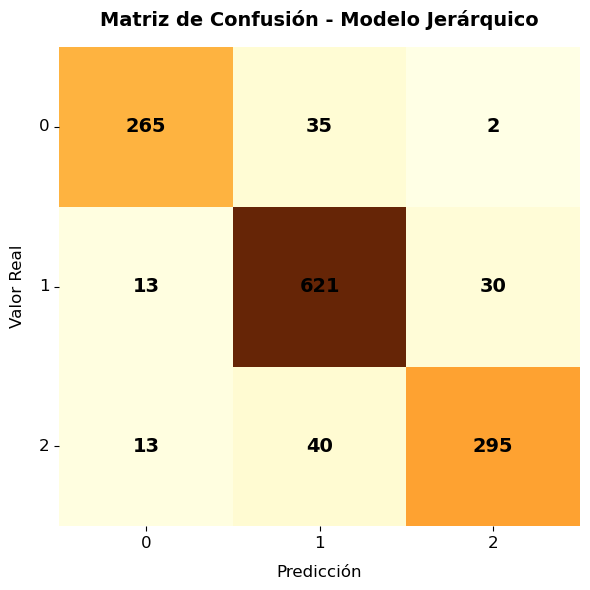

In [25]:
cm = confusion_matrix(df_modelo["Resultado_cat"], df_modelo["pred_final"])
labels = [0, 1, 2]

red_green = LinearSegmentedColormap.from_list("RedGreen", ["#ff0000", "#00ff00"])

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size":14, "weight":"bold", "color":"black"},
            cmap="YlOrBr", cbar=False, square=False)

plt.title("Matriz de Confusión - Modelo Jerárquico", fontsize=14, weight="bold", pad=15)
plt.xlabel("Predicción", fontsize=12, labelpad=10)
plt.ylabel("Valor Real", fontsize=12, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

plt.tight_layout()
plt.show()



Validacion del modelo con el dataset reservado

In [26]:
X_presencia_valfinal = df_val_final.drop(columns=["Resultado_cat", "Peligrosidad", "Fecha", "PresenciaToxina"])
X_peligrosidad_valfinal = df_val_final.drop(columns=["Resultado_cat", "PresenciaToxina", "Fecha", "Peligrosidad"])

df_val_final["presencia_pred"] = mejor_modelo_presencia.predict(X_presencia_valfinal)

df_val_final["peligrosidad_pred"] = 0

indices_con_toxina_valfinal = df_val_final[df_val_final["presencia_pred"] == 1].index
df_val_final.loc[indices_con_toxina_valfinal, "peligrosidad_pred"] = mejor_modelo_peligrosidad.predict(
    X_peligrosidad_valfinal.loc[indices_con_toxina_valfinal]
)

def clasificar_final(presencia, peligrosidad):
    if presencia == 0:
        return 0
    elif peligrosidad == 0:
        return 1
    else:
        return 2

df_val_final["pred_final"] = df_val_final.apply(
    lambda row: clasificar_final(row["presencia_pred"], row["peligrosidad_pred"]),
    axis=1
)

print("📈 Evaluación final del modelo jerárquico sobre conjunto reservado:")
print(confusion_matrix(df_val_final["Resultado_cat"], df_val_final["pred_final"]))
print(classification_report(df_val_final["Resultado_cat"], df_val_final["pred_final"]))

📈 Evaluación final del modelo jerárquico sobre conjunto reservado:
[[ 9 15 10]
 [11 45 18]
 [11 20  7]]
              precision    recall  f1-score   support

           0       0.29      0.26      0.28        34
           1       0.56      0.61      0.58        74
           2       0.20      0.18      0.19        38

    accuracy                           0.42       146
   macro avg       0.35      0.35      0.35       146
weighted avg       0.40      0.42      0.41       146



Preparacion de los datos para visualizaciones

In [27]:
df_modelo["Fecha"] = pd.to_datetime(df_modelo["Fecha"])
df_modelo["año"] = df_modelo["Fecha"].dt.year
df_modelo["mes"] = df_modelo["Fecha"].dt.month
df_modelo["día"] = df_modelo["Fecha"].dt.day

In [28]:
def codificar_error_final(row):
    real = row['Resultado_cat']
    pred = row['pred_final']
    if real == pred:
        return real  # 0, 1 o 2 según acierto
    elif real == 0 and pred == 1:
        return 3
    elif real == 0 and pred == 2:
        return 4
    elif real == 1 and pred == 0:
        return 5
    elif real == 1 and pred == 2:
        return 6
    elif real == 2 and pred == 0:
        return 7
    elif real == 2 and pred == 1:
        return 8

df_modelo["codigo_error_final"] = df_modelo.apply(codificar_error_final, axis=1)

In [29]:
leyenda_labels = {
    0: "(0) Acierto clase 0",
    1: "(1) Acierto clase 1",
    2: "(2) Acierto clase 2",
    3: "(3) Error: 0 → 1",
    4: "(4) Error: 0 → 2",
    5: "(5) Error: 1 → 0",
    6: "(6) Error: 1 → 2",
    7: "(7) Error: 2 → 0",
    8: "(8) Error: 2 → 1"
}

leyenda_colores = [
    "#2ca02c", "#1f77b4", "#ff7f0e",
    "#aec7e8", "#ffbb78", "#98df8a",
    "#f7b6d2", "#c5b0d5", "#d62728"
]

cmap = ListedColormap(leyenda_colores)
legend_patches = [Patch(color=leyenda_colores[i], label=leyenda_labels[i]) for i in range(9)]

Visualizacion de calendario con aciertos/errores de cada tipo

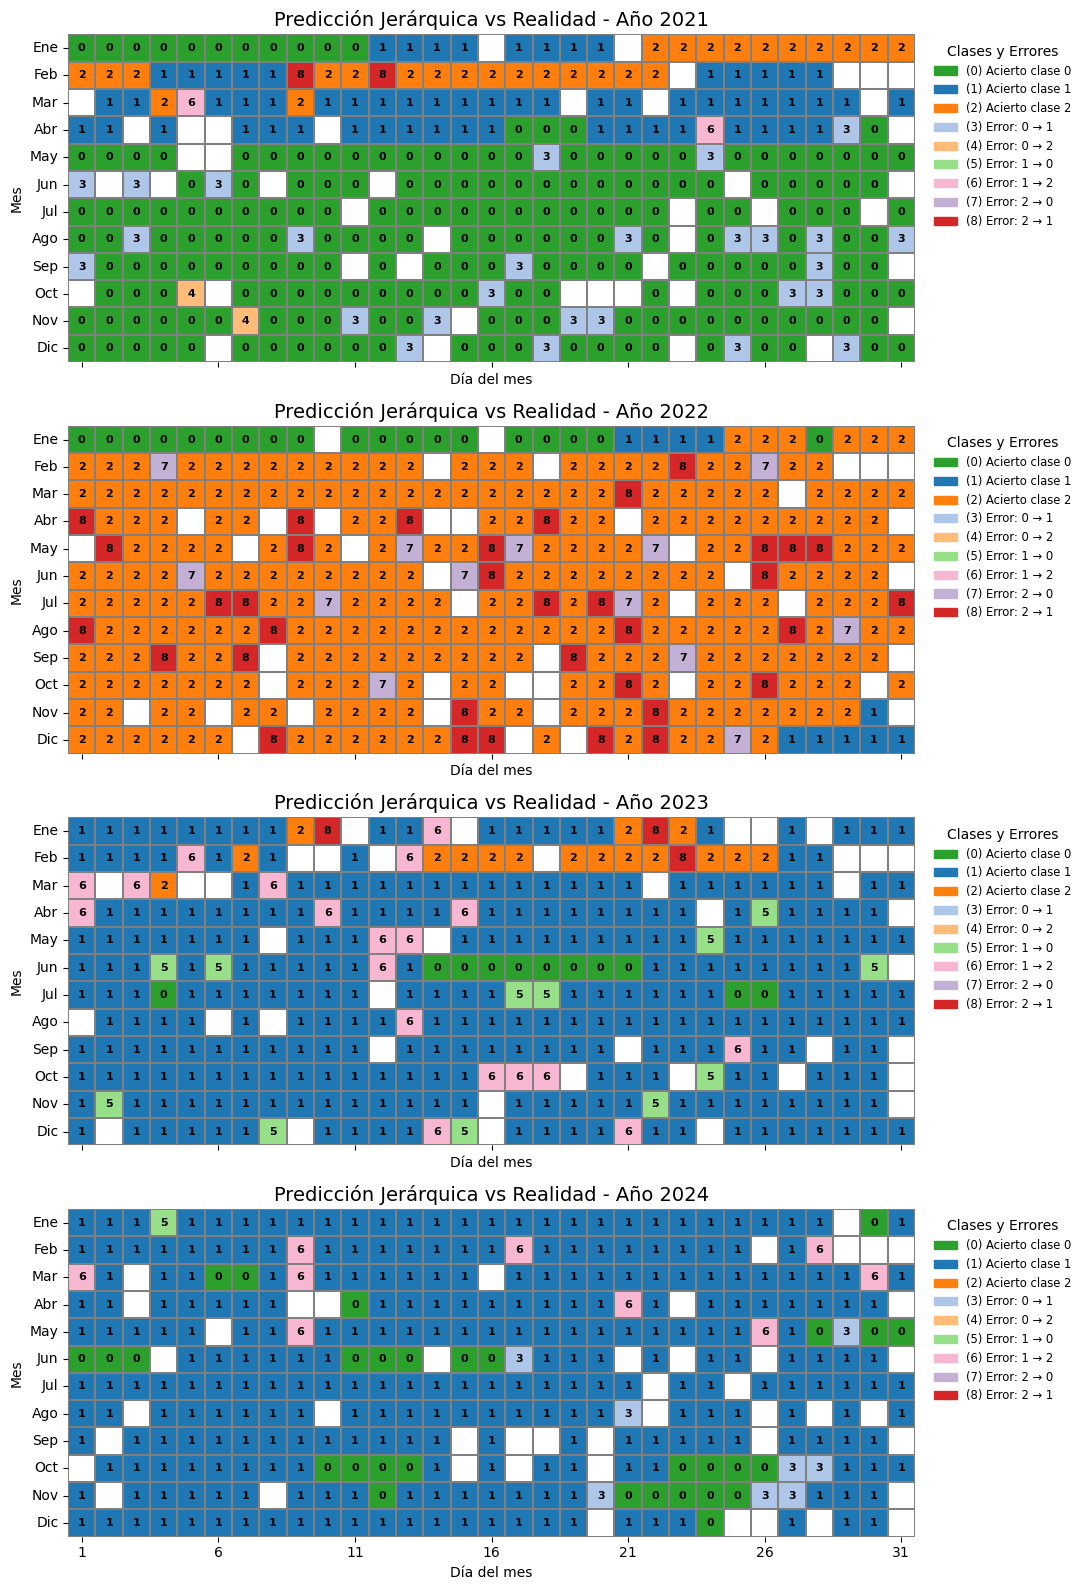

In [30]:
años = sorted(df_modelo["año"].unique())
n_años = len(años)

fig, axs = plt.subplots(n_años, 1, figsize=(24, 4 * n_años), sharex=True)

if n_años == 1:
    axs = [axs]

for i, año in enumerate(años):
    df_año = df_modelo[df_modelo["año"] == año]

    matriz = np.full((12, 31), np.nan)
    texto_matriz = np.full((12, 31), "", dtype=object)

    for _, row in df_año.iterrows():
        mes = row["mes"] - 1
        dia = row["día"] - 1
        cod = row["codigo_error_final"]
        matriz[mes, dia] = cod
        texto_matriz[mes, dia] = str(int(cod))

    ax = axs[i]
    sns.heatmap(
        matriz,
        cmap=cmap,
        cbar=False,
        ax=ax,
        linewidths=0.2,
        linecolor='gray',
        vmin=0,
        vmax=8,
        square=True,
        annot=texto_matriz,
        fmt='',
        annot_kws={"size": 8, "color": "black", "weight": "bold"}
    )

    ax.set_title(f"Predicción Jerárquica vs Realidad - Año {año}", fontsize=14)
    ax.set_ylabel("Mes")
    ax.set_yticks(np.arange(12) + 0.5)
    ax.set_yticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun",
                        "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], rotation=0)
    ax.set_xlabel("Día del mes")
    ax.set_xticks(np.arange(0, 31, 5) + 0.5)
    ax.set_xticklabels([str(d) for d in range(1, 32, 5)])

    ax.legend(handles=legend_patches, loc='upper left',
              bbox_to_anchor=(1.01, 1), fontsize='small', title="Clases y Errores", frameon=False)

plt.tight_layout()
plt.show()

Visualizacion por tipo de error

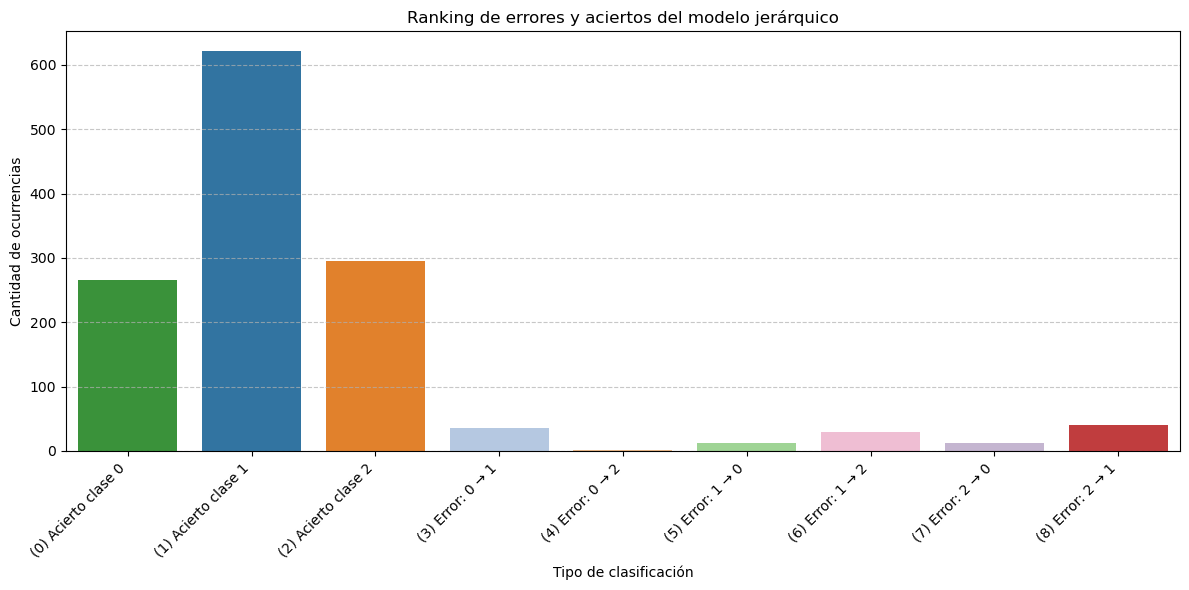

In [31]:
ranking = df_modelo["codigo_error_final"].value_counts().sort_index()

df_ranking = pd.DataFrame({
    "Código": ranking.index,
    "Descripción": [leyenda_labels[c] for c in ranking.index],
    "Frecuencia": ranking.values
})

plt.figure(figsize=(12, 6))
sns.barplot(x="Código", y="Frecuencia", data=df_ranking, palette=leyenda_colores)
plt.xticks(ticks=range(9), labels=df_ranking["Descripción"], rotation=45, ha='right')
plt.title("Ranking de errores y aciertos del modelo jerárquico")
plt.ylabel("Cantidad de ocurrencias")
plt.xlabel("Tipo de clasificación")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

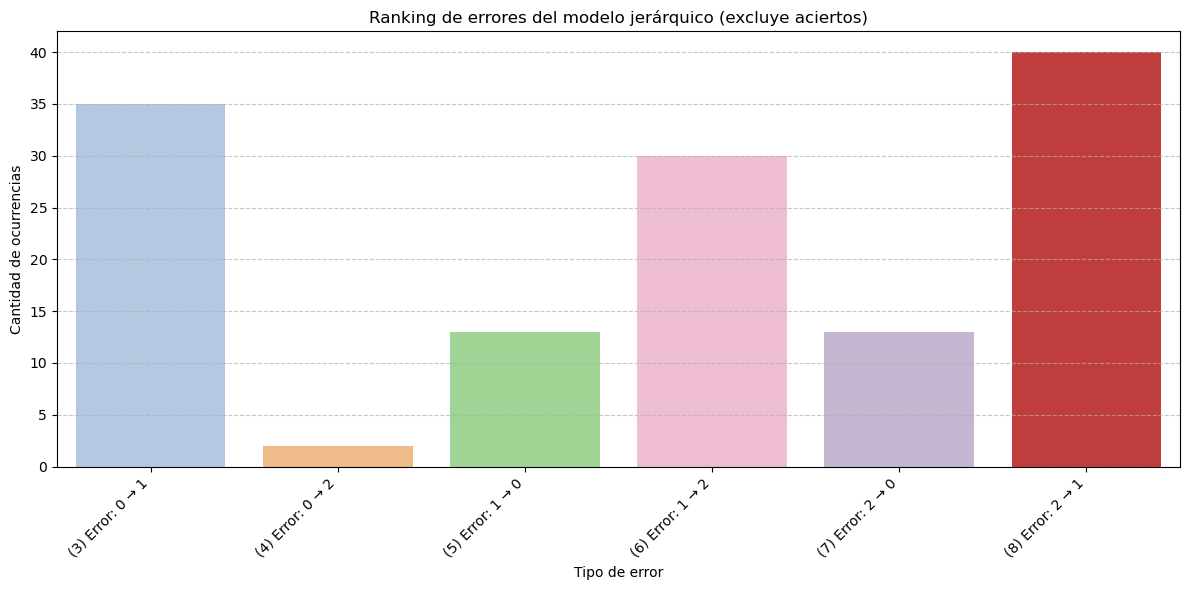

In [33]:
df_errores = df_ranking[~df_ranking["Código"].isin([0, 1, 2])]

plt.figure(figsize=(12, 6))
sns.barplot(x="Código", y="Frecuencia", data=df_errores, palette=[leyenda_colores[c] for c in df_errores["Código"]])
plt.xticks(ticks=range(len(df_errores)), labels=df_errores["Descripción"], rotation=45, ha='right')
plt.title("Ranking de errores del modelo jerárquico (excluye aciertos)")
plt.ylabel("Cantidad de ocurrencias")
plt.xlabel("Tipo de error")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()